<a href="https://colab.research.google.com/github/katelyn-hucker/xai_h10/blob/main/XAI_with_LLMs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# XAI with LLMS
### Katelyn Hucker

In this explainable technique exploration, we explore 3 different techniques: PCA, UMAP, and t-SNE for sample data on the MTEB leaderboard model, Snowflake. We can understand how Snowflake works by using these techniques and see the benefits for using XAI tools.

In [1]:
import torch
from transformers import AutoModel, AutoTokenizer
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import umap
import seaborn as sns
from umap import UMAP

In [2]:
# set a seed
np.random.seed(42)
torch.manual_seed(42)

In [3]:
# load the model
#this code was taken from hugging face documentation https://huggingface.co/Snowflake/snowflake-arctic-embed-l-v2.0#usage
model_name = 'Snowflake/snowflake-arctic-embed-l-v2.0'
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name, add_pooling_layer=False)
model.eval()

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/1.34k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.1M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/964 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/784 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.27G [00:00<?, ?B/s]

Some weights of the model checkpoint at Snowflake/snowflake-arctic-embed-l-v2.0 were not used when initializing XLMRobertaModel: ['pooler.dense.bias', 'pooler.dense.weight']
- This IS expected if you are initializing XLMRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


XLMRobertaModel(
  (embeddings): XLMRobertaEmbeddings(
    (word_embeddings): Embedding(250002, 1024, padding_idx=1)
    (position_embeddings): Embedding(8194, 1024, padding_idx=1)
    (token_type_embeddings): Embedding(1, 1024)
    (LayerNorm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): XLMRobertaEncoder(
    (layer): ModuleList(
      (0-23): 24 x XLMRobertaLayer(
        (attention): XLMRobertaAttention(
          (self): XLMRobertaSdpaSelfAttention(
            (query): Linear(in_features=1024, out_features=1024, bias=True)
            (key): Linear(in_features=1024, out_features=1024, bias=True)
            (value): Linear(in_features=1024, out_features=1024, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): XLMRobertaSelfOutput(
            (dense): Linear(in_features=1024, out_features=1024, bias=True)
            (LayerNorm): LayerNorm((1024,), eps=1e-05, elem

In [5]:
# sample data
#Claude Sonnet 3.7 was used to generate sample data at 8:51 am on 3/27/2025

query_prefix = 'query: '

queries = [
    #food queries
    "where can I get the best tacos?",
    "what are some example pizzas i can make",
    "how to make sushi",
    "french cuisine recipes",
    "vegetarian meal ideas",
]

documents = [

             #answers
    "Mexico City offers the most authentic tacos.",
    "Pepperoni pizza, Margherita pizza, or even buffalo chicken pizza.",
    "Sushi requires high-quality fresh fish and properly prepared rice.",
    "French cuisine emphasizes quality ingredients and elegant presentation.",
    "Vegetarian meals focus on plant-based proteins and seasonal vegetables.",

]

query_labels =  ["Food Query"] * 5
doc_labels =  ["Food Doc"] * 5

#This code was taken from hugging face documentation https://huggingface.co/Snowflake/snowflake-arctic-embed-l-v2.0#usage
queries_with_prefix = [f"{query_prefix}{q}" for q in queries]
query_tokens = tokenizer(queries_with_prefix, padding=True, truncation=True, return_tensors='pt', max_length=8192)
doc_tokens = tokenizer(documents, padding=True, truncation=True, return_tensors='pt', max_length=8192)

In [9]:
with torch.no_grad():
    query_embeddings = model(**query_tokens)[0][:, 0]
    doc_embeddings = model(**doc_tokens)[0][:, 0]



In [8]:
query_embeddings = torch.nn.functional.normalize(query_embeddings, p=2, dim=1)
doc_embeddings = torch.nn.functional.normalize(doc_embeddings, p=2, dim=1)

# Convert to numpy for visualization
query_embeddings_np = query_embeddings.numpy()
doc_embeddings_np = doc_embeddings.numpy()

# Combine all embeddings for dimensionality reduction
all_embeddings = np.vstack([query_embeddings_np, doc_embeddings_np])
all_labels = query_labels + doc_labels


In [10]:
scores = torch.mm(query_embeddings, doc_embeddings.transpose(0, 1))
for query, query_scores in zip(queries, scores):
    doc_score_pairs = list(zip(documents, query_scores))
    doc_score_pairs = sorted(doc_score_pairs, key=lambda x: x[1], reverse=True)
    #Output passages & scores
    print("Query:", query)
    for document, score in doc_score_pairs:
        print(score, document)

Query: where can I get the best tacos?
tensor(110.9824) Mexico City offers the most authentic tacos.
tensor(37.3459) Pepperoni pizza, Margherita pizza, or even buffalo chicken pizza.
tensor(24.0224) Sushi requires high-quality fresh fish and properly prepared rice.
tensor(15.3595) French cuisine emphasizes quality ingredients and elegant presentation.
tensor(14.3837) Vegetarian meals focus on plant-based proteins and seasonal vegetables.
Query: what are some example pizzas i can make
tensor(108.4752) Pepperoni pizza, Margherita pizza, or even buffalo chicken pizza.
tensor(21.3342) Sushi requires high-quality fresh fish and properly prepared rice.
tensor(17.4892) Vegetarian meals focus on plant-based proteins and seasonal vegetables.
tensor(7.9326) French cuisine emphasizes quality ingredients and elegant presentation.
tensor(3.6357) Mexico City offers the most authentic tacos.
Query: how to make sushi
tensor(92.9981) Sushi requires high-quality fresh fish and properly prepared rice.
te

###PCA

In [11]:
#PCA

pca = PCA(n_components=2)
pca_result = pca.fit_transform(all_embeddings)

In [17]:
palette = {
    "Food Query": "blue",
    "Food Doc": "gray",
}

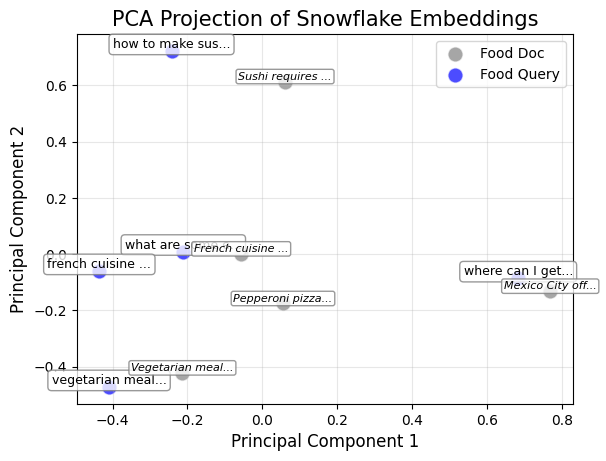

In [22]:
for label in set(all_labels):
    idx = [i for i, l in enumerate(all_labels) if l == label]
    plt.scatter(pca_result[idx, 0], pca_result[idx, 1], label=label, alpha=0.7,
                color=palette[label], s=120, edgecolors='w')

#Claude Sonnet 3.7 was used to put the labels on data points for easier analysis at 9:06am 3/27/2025
texts = []
for i in range(len(queries)):
    short_text = queries[i][:15] + '...' if len(queries[i]) > 15 else queries[i]
    texts.append(plt.text(pca_result[i, 0], pca_result[i, 1], short_text,
                         fontsize=9, ha='center', va='bottom',
                         bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8)))

#same generated code from above just changed for documents.
for i in range(len(queries), len(all_labels)):
    doc_idx = i - len(queries)
    short_text = documents[doc_idx][:15] + '...'
    texts.append(plt.text(pca_result[i, 0], pca_result[i, 1], short_text,
                         fontsize=8, ha='center', va='bottom', style='italic',
                         bbox=dict(boxstyle="round,pad=0.2", fc="white", ec=palette[all_labels[i]], alpha=0.8)))

plt.title('PCA Projection of Snowflake Embeddings', fontsize=15)
plt.xlabel('Principal Component 1', fontsize=12)
plt.ylabel('Principal Component 2', fontsize=12)
plt.legend(fontsize=10)
plt.grid(alpha=0.3)
plt.show()

### PCA Discussion

The Principal Component Analysis visualization shows the relationship between the queries and the database information. We find that the tacos, vegetarian, and sushi query/db pairing are closely related. However, the french cuisine and pizza pariring may not be as strong. French cuisine is closer to pizza examples then french cuisine. This may be due to the french and italian food are probably the closest pairing I have within the pairings so this makes some sense. I think it is interesting that tacos and sushi anre the most separated from the rest of the data.

### tSNE

In [36]:
# tsne
tsne = TSNE(n_components=2, perplexity=2, max_iter=1000, random_state=42)
tsne_result = tsne.fit_transform(all_embeddings)

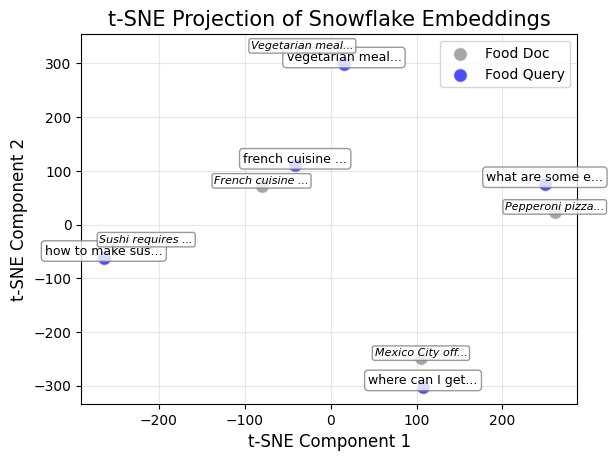

In [37]:
for label in set(all_labels):
    idx = [i for i, l in enumerate(all_labels) if l == label]
    plt.scatter(tsne_result[idx, 0], tsne_result[idx, 1], label=label, alpha=0.7,
                color=palette[label], s=100, edgecolors='w')

#same generated code from above just changed for tsne.
texts = []
for i in range(len(queries)):
    short_text = queries[i][:15] + '...' if len(queries[i]) > 15 else queries[i]
    texts.append(plt.text(tsne_result[i, 0], tsne_result[i, 1], short_text,
                         fontsize=9, ha='center', va='bottom',
                         bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8)))

#same generated code from above just changed for tsne.
for i in range(len(queries), len(all_labels)):
    doc_idx = i - len(queries)
    short_text = documents[doc_idx][:15] + '...'
    texts.append(plt.text(tsne_result[i, 0],tsne_result[i, 1], short_text,
                         fontsize=8, ha='center', va='bottom', style='italic',
                         bbox=dict(boxstyle="round,pad=0.2", fc="white", ec=palette[all_labels[i]], alpha=0.8)))

plt.title('t-SNE Projection of Snowflake Embeddings', fontsize=15)
plt.xlabel('t-SNE Component 1', fontsize=12)
plt.ylabel('t-SNE Component 2', fontsize=12)
plt.legend(fontsize=10)
plt.grid(alpha=0.3)

### t-SNE discussion

t-SNE shows significant better pairings and separation then PCA does. This may be due to the additional t-SNE flags we used like perplexity. The low perplexity value means it will not look past many points when plotting on the components. There is no confusion between queries and document pairings. They also show good separation between the pairings, that is, they are not similar and that is shown in the plot.

### UMAP

In [33]:
umap_reducer = UMAP(n_components=2, n_neighbors=2, min_dist=0.1, random_state=42)
umap_result = umap_reducer.fit_transform(all_embeddings)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


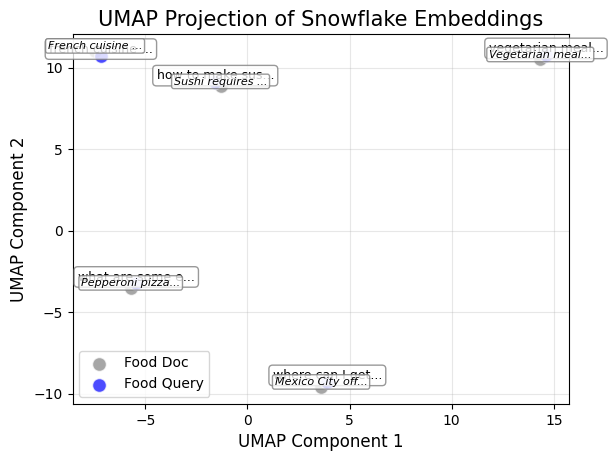

In [34]:
for label in set(all_labels):
    idx = [i for i, l in enumerate(all_labels) if l == label]
    plt.scatter(umap_result[idx, 0], umap_result[idx, 1], label=label, alpha=0.7,
                color=palette[label], s=100, edgecolors='w')

#same generated code from above just changed for tsne.
texts = []
for i in range(len(queries)):
    short_text = queries[i][:15] + '...' if len(queries[i]) > 15 else queries[i]
    texts.append(plt.text(umap_result[i, 0], umap_result[i, 1], short_text,
                         fontsize=9, ha='center', va='bottom',
                         bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8)))

#same generated code from above just changed for tsne.
for i in range(len(queries), len(all_labels)):
    doc_idx = i - len(queries)
    short_text = documents[doc_idx][:15] + '...'
    texts.append(plt.text(umap_result[i, 0],umap_result[i, 1], short_text,
                         fontsize=8, ha='center', va='bottom', style='italic',
                         bbox=dict(boxstyle="round,pad=0.2", fc="white", ec=palette[all_labels[i]], alpha=0.8)))

plt.title('UMAP Projection of Snowflake Embeddings', fontsize=15)
plt.xlabel('UMAP Component 1', fontsize=12)
plt.ylabel('UMAP Component 2', fontsize=12)
plt.legend(fontsize=10)
plt.grid(alpha=0.3)

### UMAP discussion

The query and document pairing is the closest it has been with UMAP. I believe this is due to the flag n_neighbors. The n_neighbors flag means its only searching for 2 points which are the closest giving the points less options for similarity. I did this to keep equality between UMAP and t-SNE. UMAP most closely patches the queries to documents.

### Overall discussion

UMAP and t-SNE perform signficantly better, than PCA, with UMAP being the best. However, UMAP and t-SNE are harder to explain and understand to stakeholders than PCA. PCA is similar to a regression framework making it easier to explain and understand how it gets the results. UMAP and t-SNE are more 'you understand at face value, but do you really understand' style of tools. UMAP and t-SNE should be used for more complex data and models specifically when we reduce dimensions or are dealing with large amounts of classes as they can have more specificity for the data types.

### Sources

Claude Sonnet 3.7 was used to generate sample data and plot the different labels for display. This is cited where it occurs.

https://huggingface.co/Snowflake/snowflake-arctic-embed-l-v2.0#usage

https://huggingface.co/spaces/mteb/leaderboard
